In [28]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T


import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn

from torchvision.utils import save_image

# progress bar 
from tqdm.notebook import tqdm 
import torch.nn.functional as F

In [2]:
image_size = 64 
batch_size = 128 
# means of 0.5 and standard deviation 0.5
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [3]:
train_ds = ImageFolder('../input/animefacedataset/', transform=T.Compose([
    T.Resize(image_size),
    # converting image 
    T.CenterCrop(image_size),
    # CentreCrop image 
    T.ToTensor(),
    # coverting image into tensor 
    T.Normalize(*stats)]))
    # Normalizing dataset (mean substract then diveide standard deviation )

train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=2, 
                      pin_memory=True)

In [7]:
# for denormalizing image -> original value 
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [8]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

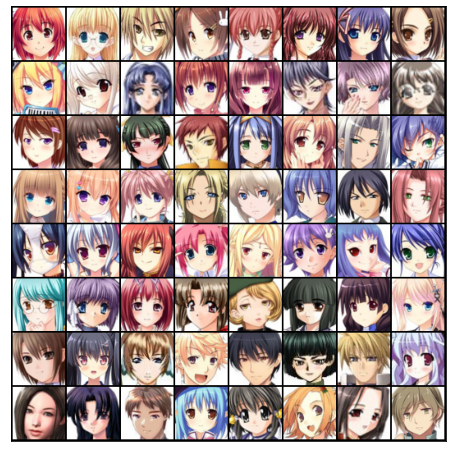

In [9]:
show_batch(train_dl)

In [10]:
# function for checking gpu device
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    #it will a tensor or model and move to a specific device  
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


# it will load data to device 
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
# to check we have gpu or cpu
device = get_default_device()
device

device(type='cuda')

In [12]:
# loading data to device 
train_dl = DeviceDataLoader(train_dl, device)

In [13]:
# sequence of layer 
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # activation function
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())
# it will convert output in 0 or 1

In [14]:
discriminator = to_device(discriminator, device)

In [15]:
latent_size = 128

In [16]:
# generator network -> it will take a vector of random number - tensor  and 
# generator will use this tensor as a seeds to generate image
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


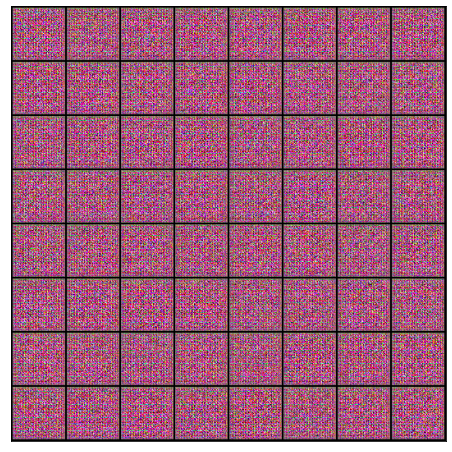

In [17]:
# creating a latent tensor 
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
# generator will generate fake images 
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

# we did not trained your generator show this is creating noising images

In [18]:
generator = to_device(generator, device)

In [19]:
# probability training our descrminator 
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    # after backword descriminator will able to predict more accurate images
    opt_d.step() #it will update weights 
    return loss.item(), real_score, fake_score

In [20]:
# training our generator 
# -> genrator ko es tarah hume train krna hai ki vo descriminator ko fool ban ske 
# in this we will not update our discreminator , instead we will use loss of descriminator to train our generator 
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [22]:
import os
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [24]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [26]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


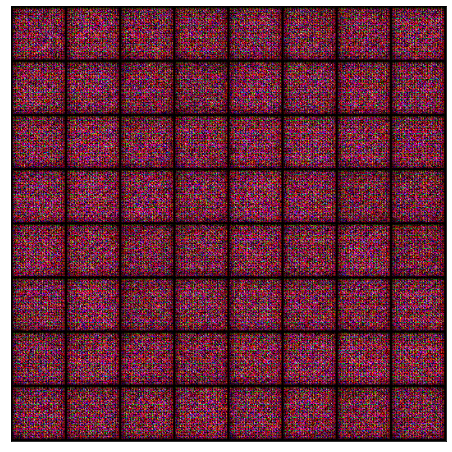

In [27]:
save_samples(0, fixed_latent)

In [29]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [31]:
lr = 0.0002
epochs = 50

In [32]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/50], loss_g: 5.7716, loss_d: 0.7975, real_score: 0.8198, fake_score: 0.3869
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 4.8539, loss_d: 0.2982, real_score: 0.8161, fake_score: 0.0452
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 5.5388, loss_d: 0.3341, real_score: 0.8853, fake_score: 0.1690
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/50], loss_g: 7.4272, loss_d: 0.4881, real_score: 0.6694, fake_score: 0.0025
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/50], loss_g: 5.3135, loss_d: 0.3937, real_score: 0.7225, fake_score: 0.0082
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/50], loss_g: 9.5611, loss_d: 0.6466, real_score: 0.9833, fake_score: 0.4068
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/50], loss_g: 4.3459, loss_d: 0.2196, real_score: 0.8526, fake_score: 0.0298
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/50], loss_g: 4.6433, loss_d: 0.0546, real_score: 0.9590, fake_score: 0.0107
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/50], loss_g: 6.7399, loss_d: 0.0459, real_score: 0.9761, fake_score: 0.0206
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/50], loss_g: 3.8363, loss_d: 0.1729, real_score: 0.9099, fake_score: 0.0652
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/50], loss_g: 3.1344, loss_d: 0.4296, real_score: 0.7482, fake_score: 0.0425
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/50], loss_g: 1.8938, loss_d: 0.3983, real_score: 0.7185, fake_score: 0.0088
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/50], loss_g: 10.9873, loss_d: 1.3664, real_score: 0.9869, fake_score: 0.6239
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/50], loss_g: 4.3264, loss_d: 0.2789, real_score: 0.8405, fake_score: 0.0672
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/50], loss_g: 3.9412, loss_d: 0.2502, real_score: 0.8863, fake_score: 0.1010
Saving generated-images-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/50], loss_g: 4.0383, loss_d: 0.1390, real_score: 0.9419, fake_score: 0.0700
Saving generated-images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/50], loss_g: 6.3522, loss_d: 0.3778, real_score: 0.9648, fake_score: 0.2602
Saving generated-images-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/50], loss_g: 4.8754, loss_d: 0.1715, real_score: 0.9639, fake_score: 0.1105
Saving generated-images-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/50], loss_g: 3.0638, loss_d: 0.1445, real_score: 0.9189, fake_score: 0.0497
Saving generated-images-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/50], loss_g: 0.0104, loss_d: 4.2905, real_score: 0.0370, fake_score: 0.0000
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/50], loss_g: 3.8157, loss_d: 0.2567, real_score: 0.8263, fake_score: 0.0470
Saving generated-images-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/50], loss_g: 5.3390, loss_d: 0.6249, real_score: 0.9941, fake_score: 0.3736
Saving generated-images-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/50], loss_g: 4.8627, loss_d: 0.1198, real_score: 0.9789, fake_score: 0.0844
Saving generated-images-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/50], loss_g: 4.1946, loss_d: 0.1570, real_score: 0.9404, fake_score: 0.0825
Saving generated-images-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/50], loss_g: 5.4506, loss_d: 0.1379, real_score: 0.9735, fake_score: 0.0985
Saving generated-images-0025.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [26/50], loss_g: 3.9812, loss_d: 0.1067, real_score: 0.9289, fake_score: 0.0276
Saving generated-images-0026.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [27/50], loss_g: 4.3324, loss_d: 0.0645, real_score: 0.9680, fake_score: 0.0298
Saving generated-images-0027.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [28/50], loss_g: 5.6806, loss_d: 0.1535, real_score: 0.9845, fake_score: 0.1185
Saving generated-images-0028.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [29/50], loss_g: 3.9290, loss_d: 0.1153, real_score: 0.9299, fake_score: 0.0333
Saving generated-images-0029.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [30/50], loss_g: 3.9003, loss_d: 0.1193, real_score: 0.9246, fake_score: 0.0335
Saving generated-images-0030.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [31/50], loss_g: 5.0327, loss_d: 0.1692, real_score: 0.9628, fake_score: 0.1049
Saving generated-images-0031.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [32/50], loss_g: 5.7806, loss_d: 0.0570, real_score: 0.9699, fake_score: 0.0241
Saving generated-images-0032.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [33/50], loss_g: 5.9237, loss_d: 0.0327, real_score: 0.9819, fake_score: 0.0137
Saving generated-images-0033.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [34/50], loss_g: 1.5954, loss_d: 0.1978, real_score: 0.8435, fake_score: 0.0098
Saving generated-images-0034.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [35/50], loss_g: 4.7526, loss_d: 0.0705, real_score: 0.9785, fake_score: 0.0436
Saving generated-images-0035.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [36/50], loss_g: 6.9313, loss_d: 0.3462, real_score: 0.9951, fake_score: 0.2399
Saving generated-images-0036.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [37/50], loss_g: 5.3970, loss_d: 0.0423, real_score: 0.9876, fake_score: 0.0278
Saving generated-images-0037.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [38/50], loss_g: 4.5298, loss_d: 0.1194, real_score: 0.9484, fake_score: 0.0552
Saving generated-images-0038.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [39/50], loss_g: 6.9893, loss_d: 0.0955, real_score: 0.9887, fake_score: 0.0760
Saving generated-images-0039.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [40/50], loss_g: 4.7338, loss_d: 0.0464, real_score: 0.9812, fake_score: 0.0253
Saving generated-images-0040.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [41/50], loss_g: 4.6277, loss_d: 0.0562, real_score: 0.9745, fake_score: 0.0275
Saving generated-images-0041.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [42/50], loss_g: 4.4656, loss_d: 0.0711, real_score: 0.9535, fake_score: 0.0192
Saving generated-images-0042.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [43/50], loss_g: 4.3131, loss_d: 0.2044, real_score: 0.9429, fake_score: 0.1129
Saving generated-images-0043.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [44/50], loss_g: 4.8967, loss_d: 0.0499, real_score: 0.9636, fake_score: 0.0115
Saving generated-images-0044.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [45/50], loss_g: 4.4614, loss_d: 0.0520, real_score: 0.9646, fake_score: 0.0141
Saving generated-images-0045.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [46/50], loss_g: 1.2057, loss_d: 1.4277, real_score: 0.3438, fake_score: 0.0077
Saving generated-images-0046.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [47/50], loss_g: 4.4656, loss_d: 0.0457, real_score: 0.9684, fake_score: 0.0121
Saving generated-images-0047.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [48/50], loss_g: 2.9585, loss_d: 0.4851, real_score: 0.8878, fake_score: 0.2499
Saving generated-images-0048.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [49/50], loss_g: 8.8117, loss_d: 0.2061, real_score: 0.9966, fake_score: 0.1559
Saving generated-images-0049.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [50/50], loss_g: 2.6900, loss_d: 0.1708, real_score: 0.8804, fake_score: 0.0188
Saving generated-images-0050.png


In [33]:
# generate a video output from the images 
# import cv2
# import os

# vid_fname = 'gans_training.mp4'

# files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
# files.sort()

# out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
# [out.write(cv2.imread(fname)) for fname in files]
# out.release()